In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(excel_path, image_dir):
    df = pd.read_excel(excel_path)
    images = []
    labels = []
    classification_labels = []
    coordinates_labels = []

    for _, row in df.iterrows():
        img_path = f"{image_dir}/{row['image_name']}"
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))  # Resize for MobileNetV2

        # Append images and corresponding stick coordinates (or None if missing)
        #images.append(image)
        #label = [row['small_start_x'], row['small_start_y'], row['small_end_x'], row['small_end_y'],
        #         row['big_start_x'], row['big_start_y'], row['big_end_x'], row['big_end_y']]
        #labels.append(label)
        images.append(image)

        # Determine classification label
        small_stick_present = not pd.isnull(row['small_start_x'])
        big_stick_present = not pd.isnull(row['big_start_x'])

        classification_labels.append([int(small_stick_present), int(big_stick_present)])

        coordinates = [
            (row['small_start_x'] * 224) / 1920 if not pd.isnull(row['small_start_x']) else 0,
            (row['small_start_y']* 224) / 1080 if not pd.isnull(row['small_start_y']) else 0,
            (row['small_end_x']* 224) / 1920 if not pd.isnull(row['small_end_x']) else 0,
            (row['small_end_y']* 224) / 1080 if not pd.isnull(row['small_end_y']) else 0,
            (row['big_start_x']* 224) / 1920 if not pd.isnull(row['big_start_x']) else 0,
            (row['big_start_y']* 224) / 1080 if not pd.isnull(row['big_start_y']) else 0,
            (row['big_end_x']* 224) / 1920 if not pd.isnull(row['big_end_x']) else 0,
            (row['big_end_y']* 224) / 1080 if not pd.isnull(row['big_end_y']) else 0
        ]
        coordinates_labels.append(coordinates)

    return np.array(images), np.array(classification_labels), np.array(coordinates_labels)

In [ ]:
images, classification_labels, coordinates_labels = load_data('/content/drive/My Drive/imageAndLabels.xlsx', '/content/drive/My Drive/filtered_images')

# Normalize images and handle missing labels (replace missing values with 0 or other logic)
images = images / 255.0


In [ ]:
coordinates_labels[0]

array([110.83333333, 122.37037037, 140.46666667,  71.55555556,
         0.        ,   0.        ,   0.        ,   0.        ])

In [ ]:
# One-hot encode classification labels (for multi-class classification)
#encoder = OneHotEncoder(sparse=False)
#classification_labels = encoder.fit_transform(classification_labels.reshape(-1, 1))

# Split the data into training and validation sets
X_train, X_val, y_class_train, y_class_val, y_coord_train, y_coord_val = train_test_split(
    images, classification_labels, coordinates_labels, test_size=0.2, random_state=42
)

In [ ]:
y_class_train[29]

array([1, 1])

In [ ]:
# Transfer Learning Model - Use MobileNetV2
#base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output layers for classification and stick coordinates regression
stick_classification = Dense(2, activation='sigmoid', name='stick_classification')(x)
stick_coordinates = Dense(8, name='stick_coordinates')(x)

# Final model


In [ ]:
from tensorflow.keras.optimizers import Adam

model = Model(inputs=base_model.input, outputs=[stick_classification, stick_coordinates])

# Compile the model
model.compile(optimizer='adam',
              loss={'stick_classification': 'binary_crossentropy', 'stick_coordinates': 'mean_squared_error'},
              metrics={'stick_classification': 'accuracy', 'stick_coordinates': 'mae'})

# Train the model
model.fit(X_train, [y_class_train, y_coord_train],
          validation_data=(X_val, [y_class_val, y_coord_val]),
          epochs=10, batch_size=16)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - loss: 13673.9805 - stick_classification_accuracy: 0.0639 - stick_coordinates_mae: 103.0405 - val_loss: 11774.6543 - val_stick_classification_accuracy: 0.0543 - val_stick_coordinates_mae: 94.4347
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - loss: 11279.1494 - stick_classification_accuracy: 0.0281 - stick_coordinates_mae: 92.5782 - val_loss: 9748.5186 - val_stick_classification_accuracy: 0.0543 - val_stick_coordinates_mae: 84.8000
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - loss: 9373.6201 - stick_classification_accuracy: 0.0363 - stick_coordinates_mae: 83.2208 - val_loss: 8114.7607 - val_stick_classification_accuracy: 0.0543 - val_stick_coordinates_mae: 76.4167
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - loss: 7792.6689 - stick_classification_accuracy: 0.1593 - stick_coordinates_mae: 74.7327 - val_loss: 6815.8501 - val_stick_classification_accuracy: 0.0543 - val_stick_coordinates_mae: 69.2464
Epoch 5/10
55/55

In [ ]:
model.save('stick_classifier_model_mobilenet.h5')

In [ ]:
## Preprocess the frame
#frame = cv2.imread('/content/8_frame_0013.jpeg')
frame = cv2.imread('/content/photo.jpg')
print(frame.shape)
input_frame = cv2.resize(frame, (224, 224))
print(input_frame.shape)
input_frame = np.expand_dims(input_frame, axis=0) / 255.0

# Predict stick classification and coordinates
predictions = model.predict(input_frame)
class_pred, coord_pred = predictions[0], predictions[1]

print(class_pred, coord_pred)
print(max(class_pred[0]))

(480, 640, 3)
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
[[3.9683578e-12 2.1162568e-07 2.2701586e-07 9.9999952e-01]] [[ 93.766495  69.41726   96.13206   97.04366   90.36842   61.33789
   97.90204  107.65475 ]]
0.9999995


In [ ]:
def draw_heatmap(frame, stick_coordinates):
    heatmap = np.zeros_like(frame[:, :, 0], dtype=np.float32)

    # Draw heatmap lines for small and big sticks
    if not np.isnan(stick_coordinates[0:4]).any():  # If small stick exists
        heatmap = cv2.line(heatmap,
                           (int(stick_coordinates[0]), int(stick_coordinates[1])),
                           (int(stick_coordinates[2]), int(stick_coordinates[3])),
                           1, thickness=5)

    if not np.isnan(stick_coordinates[4:]).any():  # If big stick exists
        heatmap = cv2.line(heatmap,
                           (int(stick_coordinates[4]), int(stick_coordinates[5])),
                           (int(stick_coordinates[6]), int(stick_coordinates[7])),
                           1, thickness=5)

    heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)  # Smoothen the heatmap

    # Normalize heatmap for color mapping
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay the heatmap on the original frame
    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

    return overlay

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


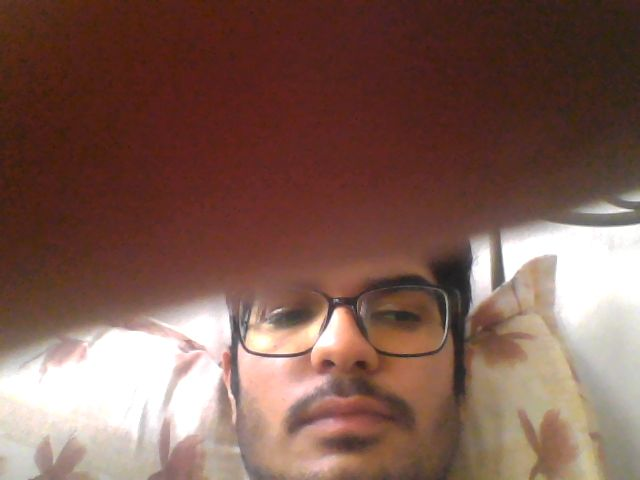

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

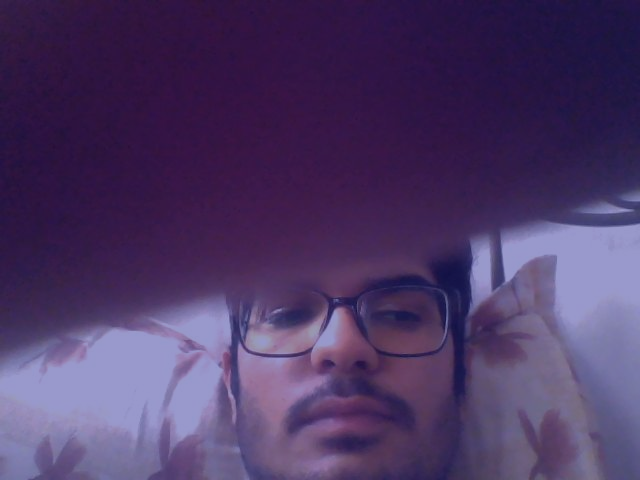

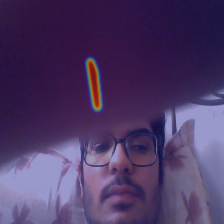

In [ ]:
from google.colab.patches import cv2_imshow
#image_path = '/content/8_frame_0013.jpeg'
image_path = '/content/photo.jpg'
image = cv2.imread(image_path)

# Define the new dimensions
new_width = 224
new_height = 224

# Resize the image
resized_image = cv2.resize(image, (new_width, new_height))
frame_with_heatmap = draw_heatmap(image, [829,387,1391,214,1234,144,1756,506])
#resized_image = draw_heatmap(resized_image, [(829*224)/1920,(387*224)/1080,(1391*224)/1920,(214*224)/1080,(1234*224)/1920,(144*224)/1080,(1756*224)/1920,(506*224)/1080])
resized_image = draw_heatmap(resized_image, list(coord_pred[0]))
 #[(829*224)/1920,(387*224)/1080,(1391*224)/1920,(214*224)/1080,(1234*224)/1920,(144*224)/1080,(1756*224)/1920,(506*224)/1080])

# Display the original and resized images
cv2_imshow( frame_with_heatmap)
cv2_imshow( resized_image)

# Wait for a key press and close the windows
cv2.waitKey(0)
cv2.destroyAllWindows()